In [184]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
colours = sns.color_palette("husl", 8)
cs = [colours[i] for i in range(len(colours))]
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Load Data

In [185]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "14", "35", "37", "69", "328", "6"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69
data["6"] = b_6

# need to swap the inbound and outbound labels for data before 12/05/20 because 
# I noted them down wrong from the data collection stage
def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    
    df.loc[df['direction'] == 'out', 'direction'] = 'inbound'
    df.loc[df['direction'] == 'in', 'direction'] = 'outbound'
    df = df[["bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    
    df.rename(columns={'expected_arrival':'time_of_arrival'}, inplace=True)
    df = df.sort_values(by='time_of_arrival', ignore_index=True)
    return df

In [186]:
def add_extra_data(route):
    if route != "6":
        more = pd.read_csv("data/" + route + " 22-04-20.csv")
        more.loc[more['arrived'] == 1, 'arrived'] = True
        more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
        data[route] = data[route].append(more, ignore_index = True)
    
    more = pd.read_csv("data/" + route + " 12-05-20.csv")
    more.loc[more['arrived'] == 1, 'arrived'] = True
    more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    data[route] = data[route].append(more, ignore_index = True)

In [187]:
for route in routes:
    add_extra_data(route)

In [188]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (56938, 6)
BUS ROUTE:  9
Shape:  (49935, 6)
BUS ROUTE:  52
Shape:  (92505, 6)
BUS ROUTE:  267
Shape:  (50939, 6)
BUS ROUTE:  277
Shape:  (71103, 6)
BUS ROUTE:  7
Shape:  (43271, 6)
BUS ROUTE:  14
Shape:  (80413, 6)
BUS ROUTE:  35
Shape:  (50120, 6)
BUS ROUTE:  37
Shape:  (78808, 6)
BUS ROUTE:  69
Shape:  (53844, 6)
BUS ROUTE:  328
Shape:  (41514, 6)
BUS ROUTE:  6
Shape:  (84330, 6)


In [189]:
import json

stops_in_sequence_inbound = {}
stops_in_sequence_outbound = {}

for r in routes:
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/inbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_inbound[r] = stops
        
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/outbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_outbound[r] = stops
        
print(stops_in_sequence_inbound.get("52"))

Making API call to get all stops on route  452
Making API call to get all stops on route  452
Making API call to get all stops on route  9
Making API call to get all stops on route  9
Making API call to get all stops on route  52
Making API call to get all stops on route  52
Making API call to get all stops on route  267
Making API call to get all stops on route  267
Making API call to get all stops on route  277
Making API call to get all stops on route  277
Making API call to get all stops on route  7
Making API call to get all stops on route  7
Making API call to get all stops on route  14
Making API call to get all stops on route  14
Making API call to get all stops on route  35
Making API call to get all stops on route  35
Making API call to get all stops on route  37
Making API call to get all stops on route  37
Making API call to get all stops on route  69
Making API call to get all stops on route  69
Making API call to get all stops on route  328
Making API call to get all stop

## Helper Functions

In [190]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time

In [191]:
def weekday_or_weekend(given_day):
    if given_day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]:
        return "weekday"
    else:
        return "weekend"

In [192]:
def pre_lockdown(given_time):
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    
    # lockdown = March 24th 2020
    if month > 3:
        return False
    elif month == 3:
        if day >= 24:
            return False
    
    return True

In [362]:
def train_test_split(data):
    
    # partition data into 4 groups
    group1 = data.iloc[:(int(data.shape[0] / 4))]
    group2 = data.iloc[(int(data.shape[0] / 4)):(int(2 * data.shape[0] / 4))]
    group3 = data.iloc[(int(2 * data.shape[0] / 4)):(int(3 * data.shape[0] / 4))]
    group4 = data.iloc[(int(3 * data.shape[0] / 4)):]
    print(group1.shape, group2.shape, group3.shape, group4.shape)

    # get a random sample of 80% from each group to ensure the train and test
    # have similar features
    training = group1.sample(frac = 0.8)
    training = training.append(group2.sample(frac = 0.8))
    training = training.append(group3.sample(frac = 0.8))
    training = training.append(group4.sample(frac = 0.8))

    # validation is all the remaining data that wasn't chosen for the training set
    validation = data[~data.apply(tuple,1).isin(training.apply(tuple,1))]
    print(training.shape, validation.shape)
    return training, validation

## Data Preprocessing

Pick 2 stops on a route. Calculate all the journey times between them. Make a dataset with attributes time of day (split into hour slots), journey time, day of week, pre lockdown.

Choose "North End Road" to "Phillimore Gardens" on route 9 inbound

In [193]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

b_9 = data.get("9")
north_end_rd = b_9.loc[(b_9['bus_stop_name'] == 'North End Road') & (b_9['direction'] == 'inbound')]
phillimore_g = b_9.loc[(b_9['bus_stop_name'] == 'Phillimore Gardens') & (b_9['direction'] == 'inbound')]
[_, north_end_rd_id, _, _, _] = north_end_rd.iloc[0]['vehicle_id'].split('_')
[_, phillimore_id, _, _, _] = phillimore_g.iloc[0]['vehicle_id'].split('_')

print(north_end_rd.shape)
print(phillimore_g.shape)

north_end_rd.head()

(882, 5)
(902, 5)


,bus_stop_name,time_of_arrival,vehicle_id,time_of_req,direction
0,North End Road,2020-03-10 10:00:50,15447_490010357F_2020-03-10_out_0,2020-03-10 10:01:02,inbound
115,North End Road,2020-03-10 10:25:02,15460_490010357F_2020-03-10_out_0,2020-03-10 10:24:39,inbound
146,North End Road,2020-03-10 10:29:40,14575_490010357F_2020-03-10_out_0,2020-03-10 10:29:38,inbound
193,North End Road,2020-03-10 10:38:36,14537_490010357F_2020-03-10_out_0,2020-03-10 10:38:53,inbound
245,North End Road,2020-03-10 10:46:27,14558_490010357F_2020-03-10_out_0,2020-03-10 10:46:27,inbound


In [195]:
start = time.time()
attrs = []

for i, journey in phillimore_g.iterrows():
    arr_dt = convert_time_to_datetime(journey['time_of_arrival'])

    [bus_id, phillimore_id, date, direction, _] = journey['vehicle_id'].split('_')
    to_match_id = bus_id + '_' + north_end_rd_id + '_' + date + '_' + direction + '_'

    for j, match in north_end_rd.iterrows():
        if match['vehicle_id'].startswith(to_match_id):
            leave_dt = convert_time_to_datetime(match['time_of_arrival'])
            journey_time = arr_dt - leave_dt

            if (journey_time > dt.timedelta(minutes = 0)) & (journey_time < dt.timedelta(minutes = 30)):
                item = []
                item.append(journey_time)
                
                seconds = journey_time.total_seconds()
                item.append(seconds)
                
                d = dt.datetime.strptime(match['time_of_arrival'][:10], '%Y-%m-%d')
                d = calendar.day_name[d.weekday()]
                w = weekday_or_weekend(d)
                item.append(w)
                
                t = int(journey['time_of_arrival'][11:13])
                item.append(t)
                
                c = pre_lockdown(journey['time_of_arrival'])
                item.append(c)
                
                attrs.append(item)
                break

print("Getting journey times took {}".format(time.time() - start))

Getting journey times took 115.80369210243225


In [196]:
df = pd.DataFrame(attrs, columns = ['Journey Time', 'Journey Time (s)', 'Day of Week', 'Time of Day', 'Pre Lockdown'])
df.head()

,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown
0,00:09:32,572.0,weekday,10,True
1,00:10:43,643.0,weekday,10,True
2,00:09:37,577.0,weekday,10,True
3,00:08:20,500.0,weekday,10,True
4,00:06:05,365.0,weekday,11,True


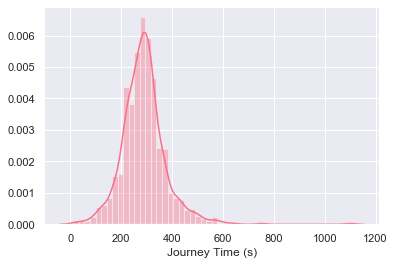

In [197]:
sns.distplot(df['Journey Time (s)'])

In [198]:
# Get rid of outliers from dataset
def detect_outlier_z_score(travel_times):
    outlier_indexes = []
    
    threshold = 3
    mean = np.mean(travel_times)
    std = np.std(travel_times)
    
    for i, t in enumerate(travel_times):
        z_score= (t - mean) / std
        
        if np.abs(z_score) > threshold:
            outlier_indexes.append(i)
    
    return outlier_indexes

outlier_indexes = detect_outlier_z_score(df['Journey Time (s)'])
print("Outlier indexes: ", outlier_indexes)
df = df.drop(outlier_indexes)

Outlier indexes:  [0, 1, 2, 105, 143, 160, 217, 259, 473, 687]


In [199]:
df.describe()

,Journey Time,Journey Time (s),Time of Day
count,820,820.000000,820.000000
mean,0 days 00:04:45.498780,285.498780,13.042683
std,0 days 00:01:17.117855,77.117855,4.302866
min,0 days 00:00:26,26.000000,5.000000
25%,0 days 00:03:59,239.000000,10.000000
50%,0 days 00:04:45,285.000000,13.000000
75%,0 days 00:05:25,325.000000,16.000000
max,0 days 00:09:04,544.000000,23.000000


In [287]:
from scipy.stats import pearsonr

dow_encoder = preprocessing.LabelEncoder()
ld_encoder = preprocessing.LabelEncoder()

dow_encoder.fit(df['Day of Week'])
encoded = dow_encoder.transform(df['Day of Week'])
df['Day of Week Encoded'] = encoded
days_of_week_label = list(dow_encoder.inverse_transform([0,1]))
print(list(zip([0,1], days_of_week_label)))
encoded = ld_encoder.fit_transform(df['Pre Lockdown'])
df['Pre Lockdown Encoded'] = encoded
pre_lockdown_label = list(ld_encoder.inverse_transform([0, 1]))
print(list(zip([0, 1], pre_lockdown_label)))

# Calculate correlation coefficient of the 3 variables
corr_tod_dow, _ = pearsonr(df['Time of Day'], df['Day of Week Encoded'])
corr_tod_pl, _ = pearsonr(df['Time of Day'], df['Pre Lockdown Encoded'])
corr_dow_pl, _ = pearsonr(df['Day of Week Encoded'], df['Pre Lockdown Encoded'])
print("Pearson Correlation Coefficient 'time of day' and 'day of 'week': ", corr_tod_dow)
print("Pearson Correlation Coefficient 'time of day' and 'pre lockdown: ", corr_tod_pl)
print("Pearson Correlation Coefficient 'day of week' and 'pre lockdown': ", corr_dow_pl)

[(0, 'weekday'), (1, 'weekend')]
[(0, False), (1, True)]
Pearson Correlation Coefficient 'time of day' and 'day of 'week':  -0.044672388328958604
Pearson Correlation Coefficient 'time of day' and 'pre lockdown:  -0.03904599312556676
Pearson Correlation Coefficient 'day of week' and 'pre lockdown':  -0.0753712601752219


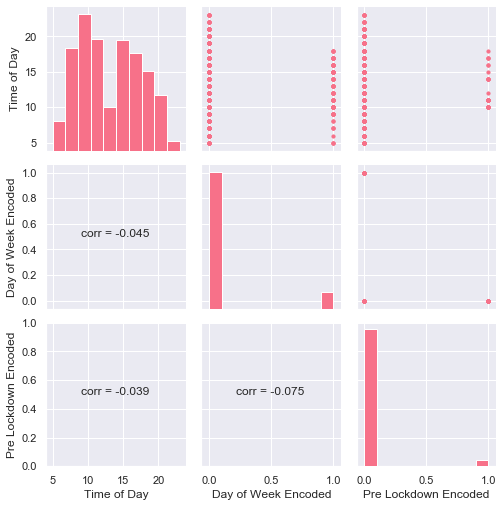

In [206]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("corr = {:.3f}".format(r),
                xy=(.25, .5), xycoords=ax.transAxes)
    
pp = sns.PairGrid(df[['Time of Day', 'Day of Week Encoded', 'Pre Lockdown Encoded']], height = 2.3, diag_sharey=False)
pp.map_upper(plt.scatter, s=10)
pp.map_diag(plt.hist)
pp.map_lower(corrfunc)

#### Feature correlation

The above pairplot indicates that the features are not related to each other, i.e. they are independent of each other. This means that they can be used together in multivariate regression. This is supported by the Pearson Correlation Coefficients calculated for the three variables. The Pearson’s correlation coefficient is calculated as the covariance of the two variables divided by the product of the standard deviation of each data sample. It is the normalization of the covariance between the two variables to give an interpretable score. The coefficient returns a value between -1 and 1 that represents the limits of correlation from a full negative correlation to a full positive correlation. A value of 0 means no correlation. The value must be interpreted, where often a value below -0.5 or above 0.5 indicates a notable correlation, and values between those values suggests a less notable correlation.

#### Feature information

There is a lot more data that was collected post lockdown compared to pre lockdown (as can be seen by the bottom right graph that has a taller 0 = False bar).
There is data for post lockdown for weekdays and weekends, but for pre lockdown there is only weekday data.
For post lockdown data there is data for all times of day that the bus runs, but for pre lockdown there is only data for between 1000 to approximately 1800.

From the middle graph, it can be seen that there is a lot more data collected on weekdays compared to weekends.
It can also be seen from the top middle graph that on weekends, there are gaps during the day where data has not been collected. For example, there is no data after approximately 1800.

From the top left graph, it can be seen that the data trend is 2 humps (perhaps morning peak and evening peak).

## Linear Regression

Regression models are generally outperformed by other types of models, but they reveal which independent variable is less/more important for predicting travel times.

Try regression models with one of the variables^2, or also do separate regression models for 1) peak weekdays vs 2) nonpeak weekdays and then 3) weekends?

#### Measures of success:

- **r2 score**, also known as coefficient of determination. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.
- **Root Mean Square Error** (rmse). Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. The smaller the better
- **Explained variance regression score** function: Best possible score is 1.0, lower values are worse. https://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score 
- **Mean Absolute Percentage Error** (MAPE): Worst is 100, lower values are better. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error

When standardized observations and forecasts are used as RMSE inputs, there is a direct relationship with the correlation coefficient. For example, if the correlation coefficient is 1, the RMSE will be 0, because all of the points lie on the regression line (and therefore there are no errors).

## Single predictor variable
### Predict journey time based on time of day

$j = b_0 + b_1t + b_2t^2$

$j = b_0 + b_1t + b_2t^2 + b_3t^3$

$j = b_0 + b_1t + b_2t^2 + b_3t^3 + b_4t^4$

where 
- $j$ is the predicted journey time
- $t$ is the time of day

This is still considered to be linear model as the coefficients/weights associated with the features are still linear. t² etc. is only a feature. However the curve that we are fitting is quadratic, cubic and quartic in nature.

It would make sense normally for time of day to have 2 peaks so that would be quartic in nature.

#### Splitting the data into training and test sets.

Need to ensure that the train and test sets are similar.

In [364]:
# Sort values by 'time of day'
df_time_of_day = df.sort_values("Time of Day")

training_time_of_day, validation_time_of_day = train_test_split(df_time_of_day)

(205, 7) (205, 7) (205, 7) (205, 7)
(656, 7) (136, 7)


In [365]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

def poly_regression_timeofday(degree):
    poly = PolynomialFeatures(degree = degree)
    poly.fit(training_time_of_day['Time of Day'][:, np.newaxis])

    x_train = poly.transform(training_time_of_day['Time of Day'][:, np.newaxis])
    x_test = poly.transform(validation_time_of_day['Time of Day'][:, np.newaxis])
    y_train = training_time_of_day['Journey Time (s)'][:, np.newaxis]
    y_test = validation_time_of_day['Journey Time (s)'][:, np.newaxis]

    # Fit model
    linreg = LinearRegression()
    linreg.fit(x_train, y_train)

    # Apply the model to the validation data to predict the ‘Journey Time’
    y_pred = linreg.predict(x_test)

    # Calculate measures of success
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_error(y_test, y_pred)

    print('Slope/Coefficients: ', linreg.coef_)
    print('Intercept: ', linreg.intercept_)
    print('The root mean squared error is: ', rmse)
    # coefficient of determination = 1 is perfect prediction
    print('The coefficient of determination is: ', r2)
    
    return y_test, y_pred, rmse, mape, linreg

y_pred_tods = []
rmse_tods = []
mape_tods = []
y_test_tod = []
model_tods = []

for i in range(1, 15):
    y_test_tod, y_pred_tod, rmse_tod, mape_tod, model = poly_regression_timeofday(i)

    y_pred_tods.append(y_pred_tod)
    rmse_tods.append(rmse_tod)
    mape_tods.append(mape_tod)
    model_tods.append(model)

Slope/Coefficients:  [[0.        0.6274955]]
Intercept:  [275.46256618]
The root mean squared error is:  85.41885166733329
The coefficient of determination is:  -0.026504718319987797
Slope/Coefficients:  [[ 0.         44.36756975 -1.62628324]]
Intercept:  [12.01028686]
The root mean squared error is:  77.85862435513769
The coefficient of determination is:  0.14716121093714218
Slope/Coefficients:  [[ 0.00000000e+00  3.94670868e+01 -1.24028762e+00 -9.44909006e-03]]
Intercept:  [31.07211142]
The root mean squared error is:  77.87998387327073
The coefficient of determination is:  0.14669321591604512
Slope/Coefficients:  [[ 0.00000000e+00  1.82122691e+01  1.38482506e+00 -1.44456658e-01
   2.46200775e-03]]
Intercept:  [91.07971913]
The root mean squared error is:  77.87886788686289
The coefficient of determination is:  0.1467176707734429
Slope/Coefficients:  [[ 0.00000000e+00 -3.61601298e+01  1.05529904e+01 -8.73868921e-01
   3.00226689e-02 -3.98130626e-04]]
Intercept:  [212.08431994]
The ro

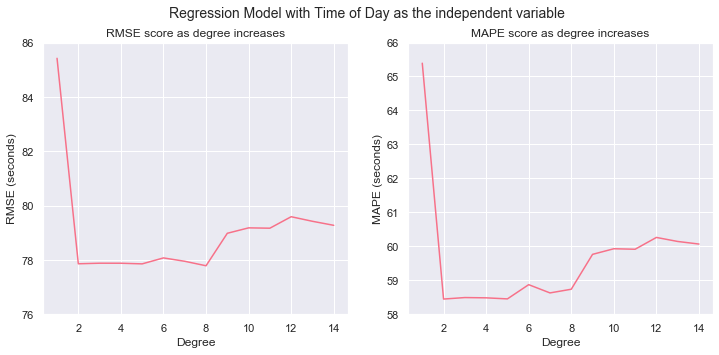

In [367]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].plot([i for i in range(1, len(rmse_tods) + 1)], rmse_tods)
ax[0].set_title("RMSE score as degree increases")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("RMSE (seconds)")
ax[0].set_ylim(76, 86)

ax[1].plot([i for i in range(1, len(mape_tods) + 1)], mape_tods)
ax[1].set_title("MAPE score as degree increases")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("MAPE (seconds)")
ax[1].set_ylim(58, 66)

fig.suptitle("Regression Model with Time of Day as the independent variable", fontsize=14)
plt.show()

In [368]:
best_rmse_tod = min(rmse_tods)
best_mape_tod = min(mape_tods)
best_rmse_tod_index = rmse_tods.index(best_rmse_tod)
best_mape_tod_index = mape_tods.index(best_mape_tod)
print(best_rmse_tod_index, best_mape_tod_index)

7 1


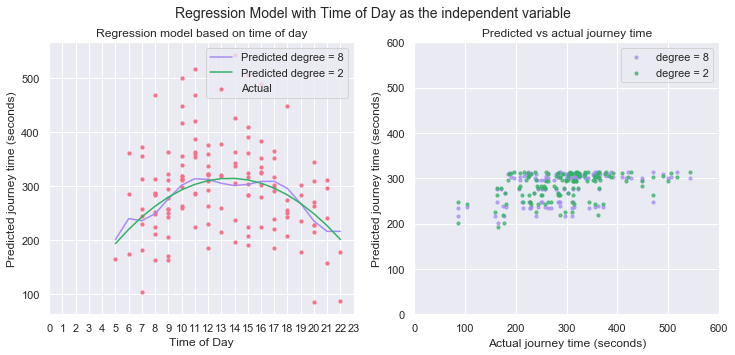

In [369]:
import operator

x = validation_time_of_day['Time of Day'][:, np.newaxis]
sort_axis = operator.itemgetter(0)
sorted_zip_mape = sorted(zip(x, y_pred_tods[best_mape_tod_index]), key=sort_axis)
x_mape, y_pred_mape = zip(*sorted_zip_mape)
sorted_zip_rmse = sorted(zip(x, y_pred_tods[best_rmse_tod_index]), key=sort_axis)
x_rmse, y_pred_rmse = zip(*sorted_zip_rmse)

# Plot outputs
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)
ax[0].scatter(x, y_test_tod, label = "Actual", s = 10)
ax[0].plot(x_rmse, y_pred_rmse, label = "Predicted degree = {}".format(best_rmse_tod_index + 1), color = cs[6])
if best_rmse_tod_index != best_mape_tod_index:
    ax[0].plot(x_mape, y_pred_mape, label = "Predicted degree = {}".format(best_mape_tod_index + 1), color = cs[3])
ax[0].set_title("Regression model based on time of day")
ax[0].set_xlabel("Time of Day")
ax[0].set_ylabel("Predicted journey time (seconds)")
ax[0].set_xticks([i for i in range(0, 24)])
ax[0].legend()

ax[1].scatter(y_test_tod, y_pred_rmse, label = "degree = {}".format(best_rmse_tod_index + 1), color = cs[6], alpha = 0.7, s = 10)
if best_rmse_tod_index != best_mape_tod_index:
    ax[1].scatter(y_test_tod, y_pred_mape, label = "degree = {}".format(best_mape_tod_index + 1), color = cs[3], alpha = 0.7, s = 10)
ax[1].set_title("Predicted vs actual journey time")
ax[1].set_xlabel("Actual journey time (seconds)")
ax[1].set_ylabel("Predicted journey time (seconds)")
ax[1].set_ylim(0, 600)
ax[1].set_xlim(0, 600)
ax[1].legend()

fig.suptitle("Regression Model with Time of Day as the independent variable", fontsize=14)
plt.show()

CONCLUSIONS:

### Predict journey time based on day of week

$j = b_0 + b_1d$

$j = b_0 + b_1d + b_2d^2$

$j = b_0 + b_1d + b_2d^2 + b_3d^3$

where 
- $j$ is the predicted journey time
- $d$ is the day of week

This is still considered to be linear model as the coefficients/weights associated with the features are still linear. d² is only a feature. However the curve that we are fitting is quadratic and cubic in nature.

Day of week would maybe have 1 peak for weekdays versus weekends so should be quadratic in nature.

#### Splitting the data into training and test sets.

Need to ensure that the train and test sets are similar.

In [370]:
# partition data into 4 groups sorted by day of week
df_day_of_week = df.sort_values("Day of Week")
training_day_of_week, validation_day_of_week = train_test_split(df_day_of_week)
training_day_of_week.head()

(205, 7) (205, 7) (205, 7) (205, 7)
(656, 7) (139, 7)


,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Day of Week Encoded,Pre Lockdown Encoded
619,00:05:01,301.0,weekday,18,False,0,0
447,00:08:18,498.0,weekday,14,False,0,0
439,00:05:20,320.0,weekday,13,False,0,0
583,00:05:23,323.0,weekday,13,False,0,0
617,00:06:14,374.0,weekday,17,False,0,0


In [371]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

def poly_regression_dayofweek(degree):
    poly = PolynomialFeatures(degree = degree)
    poly.fit(training_day_of_week['Day of Week Encoded'][:, np.newaxis])

    x_train = poly.transform(training_day_of_week['Day of Week Encoded'][:, np.newaxis])
    x_test = poly.transform(validation_day_of_week['Day of Week Encoded'][:, np.newaxis])
    y_train = training_day_of_week['Journey Time (s)'][:, np.newaxis]
    y_test = validation_day_of_week['Journey Time (s)'][:, np.newaxis]

    # Fit model
    linreg = LinearRegression()
    linreg.fit(x_train, y_train)

    # Apply the model to the validation data to predict the ‘Journey Time’
    y_pred = linreg.predict(x_test)

    # Calculate measures of success
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_error(y_test, y_pred)

    print('Slope/Coefficients: ', linreg.coef_)
    print('Intercept: ', linreg.intercept_)
    print('The root mean squared error is: ', rmse)
    # coefficient of determination = 1 is perfect prediction
    print('The coefficient of determination is: ', r2)
    
    return y_test, y_pred, rmse, mape, linreg

y_pred_dows = []
rmse_dows = []
mape_dows = []
y_test_dow = []
model_dows = []

for i in range(1, 15):
    y_test_dow, y_pred_dow, rmse_dow, mape_dow, model_dow = poly_regression_dayofweek(i)

    y_pred_dows.append(y_pred_dow)
    rmse_dows.append(rmse_dow)
    mape_dows.append(mape_dow)
    model_dows.append(model_dow)

Slope/Coefficients:  [[  0.         -15.55509468]]
Intercept:  [288.87393526]
The root mean squared error is:  83.94361495998061
The coefficient of determination is:  -0.010779926261231365
Slope/Coefficients:  [[ 0.         -7.77754734 -7.77754734]]
Intercept:  [288.87393526]
The root mean squared error is:  83.94361495998061
The coefficient of determination is:  -0.010779926261231143
Slope/Coefficients:  [[ 0.         -5.18503156 -5.18503156 -5.18503156]]
Intercept:  [288.87393526]
The root mean squared error is:  83.94361495998061
The coefficient of determination is:  -0.010779926261231143
Slope/Coefficients:  [[ 0.00000000e+00 -3.10785082e+15 -2.59186523e+15 -2.59186523e+15
   8.29158128e+15]]
Intercept:  [288.86280488]
The root mean squared error is:  83.93599668061074
The coefficient of determination is:  -0.010596468485690513
Slope/Coefficients:  [[ 0.00000000e+00 -2.97807603e+15 -2.65586960e+15 -2.65586960e+15
   4.14490761e+15  4.14490761e+15]]
Intercept:  [288.80030488]
The ro

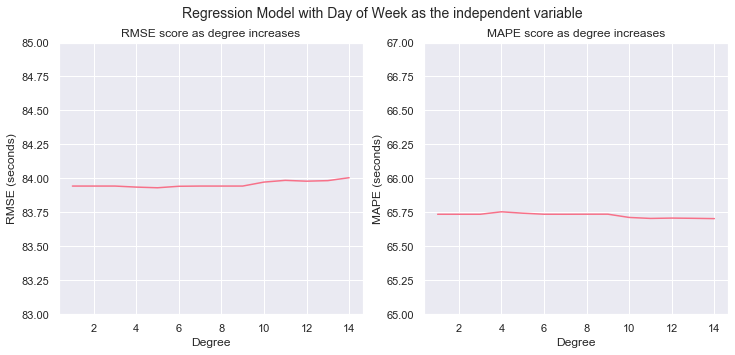

In [373]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].plot([i for i in range(1, len(rmse_dows) + 1)], rmse_dows)
ax[0].set_title("RMSE score as degree increases")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("RMSE (seconds)")
ax[0].set_ylim(83,85)

ax[1].plot([i for i in range(1, len(mape_dows) + 1)], mape_dows)
ax[1].set_title("MAPE score as degree increases")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("MAPE (seconds)")
ax[1].set_ylim(65,67)

fig.suptitle("Regression Model with Day of Week as the independent variable", fontsize=14)
plt.show()

In [374]:
best_rmse_dow = min(rmse_dows)
best_mape_dow = min(mape_dows)
best_rmse_dow_index = rmse_dows.index(best_rmse_dow)
best_mape_dow_index = mape_dows.index(best_mape_dow)
print(best_rmse_dow_index, best_mape_dow_index)

4 13


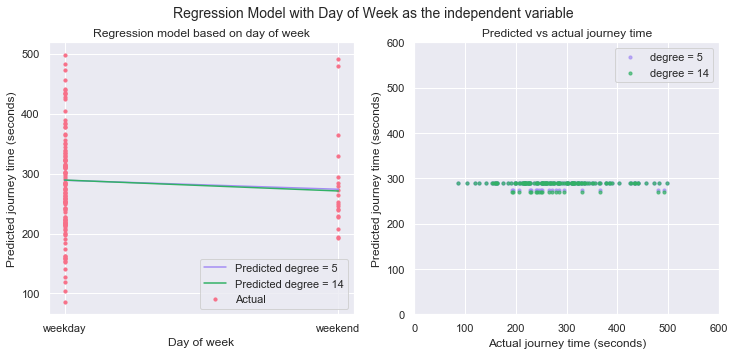

In [375]:
import operator

x = validation_day_of_week['Day of Week Encoded'][:, np.newaxis]
sort_axis = operator.itemgetter(0)
sorted_zip_mape = sorted(zip(x, y_pred_dows[best_mape_dow_index]), key=sort_axis)
x_mape, y_pred_mape = zip(*sorted_zip_mape)
sorted_zip_rmse = sorted(zip(x, y_pred_dows[best_rmse_dow_index]), key=sort_axis)
x_rmse, y_pred_rmse = zip(*sorted_zip_rmse)

# Plot outputs
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)
ax[0].scatter(x, y_test_dow, label = "Actual", s = 10)
ax[0].plot(x_rmse, y_pred_rmse, label = "Predicted degree = {}".format(best_rmse_dow_index + 1), color = cs[6])
if best_rmse_dow_index != best_mape_dow_index:
    ax[0].plot(x_mape, y_pred_mape, label = "Predicted degree = {}".format(best_mape_dow_index + 1), color = cs[3])
ax[0].set_title("Regression model based on day of week")
ax[0].set_xlabel("Day of week")
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(days_of_week_label)
ax[0].set_ylabel("Predicted journey time (seconds)")
ax[0].legend()

ax[1].scatter(y_test_dow, y_pred_rmse, label = "degree = {}".format(best_rmse_dow_index + 1), color = cs[6], alpha = 0.7, s = 10)
if best_rmse_dow_index != best_mape_dow_index:
    ax[1].scatter(y_test_dow, y_pred_mape, label = "degree = {}".format(best_mape_dow_index + 1), color = cs[3], alpha = 0.7, s = 10)
ax[1].set_title("Predicted vs actual journey time")
ax[1].set_xlabel("Actual journey time (seconds)")
ax[1].set_ylabel("Predicted journey time (seconds)")
ax[1].set_xlim(0, 600)
ax[1].set_ylim(0, 600)
ax[1].legend()

fig.suptitle("Regression Model with Day of Week as the independent variable", fontsize=14)
plt.show()

CONCLUSIONS: 

- Suggests that weekends generally have slightly shorter journey times compared to weekdays.

## Multiple predictor variables == Multiple Linear Regression

### Time of Day, Day of Week

$j = b_0 + b_1d + b_2t$

$j = b_0 + b_1d^2 + b_2dt + b_3t^2$

$j = b_0 + b_1d^3 + b_2d^2t + b_3dt^2 + b_4t^3$

where 
- $j$ is the predicted journey time
- $d$ is the day of week
- $t$ is the time of day

#### Splitting the data into training and test sets.

Need to ensure that the train and test sets are similar.

In [376]:
# partition data into 4 groups
df_mult = df.sort_values(["Time of Day", "Day of Week"])
training_mult, validation_mult = train_test_split(df_mult)
training_mult.head()

(205, 7) (205, 7) (205, 7) (205, 7)
(656, 7) (131, 7)


,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Day of Week Encoded,Pre Lockdown Encoded
174,00:04:57,297.0,weekday,9,False,0,0
291,00:04:18,258.0,weekday,9,False,0,0
642,00:05:07,307.0,weekday,6,False,0,0
60,00:04:12,252.0,weekday,9,False,0,0
520,00:05:25,325.0,weekday,9,False,0,0


In [377]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

def poly_regression_mult(degree):
    poly = PolynomialFeatures(degree = degree)
    poly.fit(training_mult[['Day of Week Encoded', 'Time of Day']])

    x_train = poly.transform(training_mult[['Day of Week Encoded', 'Time of Day']])
    x_test = poly.transform(validation_mult[['Day of Week Encoded', 'Time of Day']])
    y_train = training_mult['Journey Time (s)'][:, np.newaxis]
    y_test = validation_mult['Journey Time (s)'][:, np.newaxis]
    
    # Scale the data
    scaler = preprocessing.StandardScaler()
    scaler = scaler.fit(x_train)
    x_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Fit model
    linreg = LinearRegression()
    linreg.fit(x_scaled, y_train)

    # Apply the model to the validation data to predict the ‘Journey Time’
    y_pred = linreg.predict(x_test_scaled)

    # Calculate measures of success
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_error(y_test, y_pred)

    print('Slope/Coefficients: ', linreg.coef_)
    print('Intercept: ', linreg.intercept_)
    print('The root mean squared error is: ', rmse)
    print('The coefficient of determination is: ', r2)
    
    return y_test, y_pred, rmse, mape, linreg

y_pred_mults = []
rmse_mults = []
mape_mults = []
y_test_mult = []
model_mults = []

for i in range(1, 15):
    y_test_mult, y_pred_mult, rmse_mult, mape_mult, model_mult = poly_regression_mult(i)
    y_pred_mults.append(y_pred_mult)
    rmse_mults.append(rmse_mult)
    r2_mults.append(r2_mult)
    mape_mults.append(mape_mult)
    model_mults.append(model_mult)

Slope/Coefficients:  [[ 0.         -4.8375925   0.83814466]]
Intercept:  [285.89939024]
The root mean squared error is:  83.95079843331074
The coefficient of determination is:  -0.003954676709552629
Slope/Coefficients:  [[ 0.00000000e+00 -6.10864305e+14  1.91815985e+02  6.10864305e+14
   1.42469760e+01 -1.94559475e+02]]
Intercept:  [285.89939024]
The root mean squared error is:  77.01775532756292
The coefficient of determination is:  0.15502052611576767
Slope/Coefficients:  [[ 0.00000000e+00 -6.22783897e+14  2.16048455e+02  3.12860019e+14
   1.68616361e+12 -2.39429444e+02  3.09923878e+14 -1.68616361e+12
   6.06055389e+01  2.06200889e+01]]
Intercept:  [285.89939024]
The root mean squared error is:  77.20617130058265
The coefficient of determination is:  0.15088115924962375
Slope/Coefficients:  [[ 0.00000000e+00 -7.69166269e+14  1.32648254e+02 -1.79223456e+14
  -3.35390872e+13  3.54029084e+01 -1.75960149e+14 -2.32534725e+13
  -2.43632432e+13 -2.87332198e+02  1.12434987e+15  5.67925598e+1

Slope/Coefficients:  [[ 1.96182656e+08 -2.36506598e+13  1.44379266e+08 -6.31785464e+13
  -5.24316755e+13 -2.24450854e+09 -5.12612599e+13 -7.75178650e+13
  -1.28837302e+13  1.71578180e+10  3.73104953e+13  4.34998556e+13
  -2.42306564e+13 -3.22491141e+13 -8.39653419e+10 -5.99464424e+13
   4.64303397e+13 -2.41987360e+13 -2.31693127e+13  7.69263880e+12
   2.89592935e+11  4.00987053e+13 -7.32452684e+13  4.55755575e+13
  -2.31690289e+13  7.69109051e+12  7.65296478e+12 -7.35813477e+11
   4.00986265e+13  4.32925834e+13  4.55756308e+13  6.48174200e+13
   7.69108050e+12  7.64823127e+12  1.85092354e+13  1.40628539e+12
   4.00986651e+13  4.32925888e+13  4.55756142e+13  6.48174589e+13
   7.69106801e+12  7.64823127e+12  1.85093004e+13  3.28453773e+12
  -2.03550611e+12  4.00986651e+13 -7.32452475e+13  4.55756142e+13
  -2.31691512e+13  7.69106801e+12  7.64823127e+12  1.85093004e+13
   3.28468052e+12  3.77412408e+11  2.22222727e+12 -5.99821348e+13
   4.32925888e+13 -2.41985648e+13 -2.31691512e+13  7.69

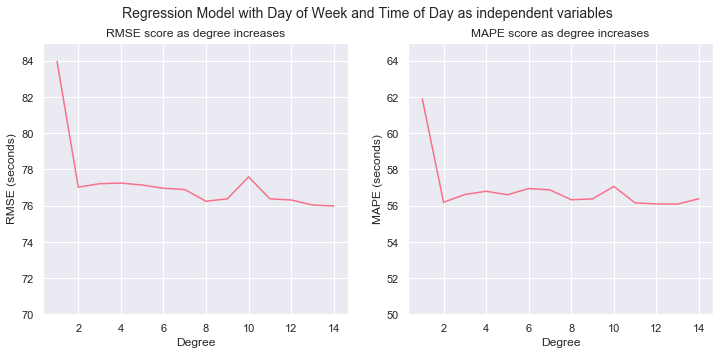

In [379]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].plot([i for i in range(1, len(rmse_mults) + 1)], rmse_mults)
ax[0].set_title("RMSE score as degree increases")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("RMSE (seconds)")
ax[0].set_ylim(70, 85)

ax[1].plot([i for i in range(1, len(mape_mults) + 1)], mape_mults)
ax[1].set_title("MAPE score as degree increases")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("MAPE (seconds)")
ax[1].set_ylim(50, 65)

fig.suptitle("Regression Model with Day of Week and Time of Day as independent variables", fontsize=14)
plt.show()

In [380]:
best_rmse_mult = min(rmse_mults)
best_mape_mult = min(mape_mults)
best_rmse_mult_index = rmse_mults.index(best_rmse_mult)
best_mape_mult_index = mape_mults.index(best_mape_mult)
print(best_rmse_mult_index, best_mape_mult_index)

13 12


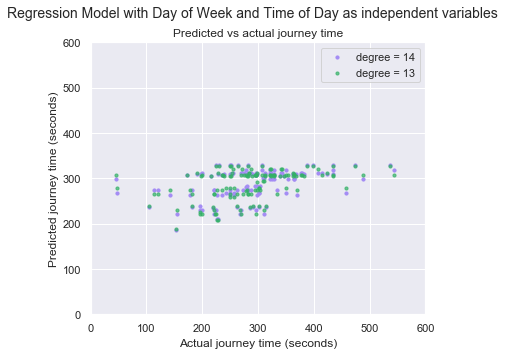

In [381]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(y_test_mult, y_pred_mults[best_rmse_mult_index], label = "degree = {}".format(best_rmse_mult_index + 1), color = cs[6], s = 10)
if best_rmse_mult_index != best_mape_mult_index:
    ax.scatter(y_test_mult, y_pred_mults[best_mape_mult_index], label = "degree = {}".format(best_mape_mult_index + 1), color = cs[3], alpha = 0.7, s = 10)
ax.set_title("Predicted vs actual journey time")
ax.set_xlabel("Actual journey time (seconds)")
ax.set_ylabel("Predicted journey time (seconds)")
ax.set_xlim(0, 600)
ax.set_ylim(0, 600)
ax.legend()

fig.suptitle("Regression Model with Day of Week and Time of Day as independent variables", fontsize=14)
plt.show()

### Time of Day, Day of Week, Pre/Post Lockdown

#### Splitting the data into training and test sets.

Need to ensure that the train and test sets are similar.

In [389]:
# partition data into 4 groups
df_mult2 = df.sort_values(["Pre Lockdown", "Time of Day", "Day of Week"])
training_mult2, validation_mult2 = train_test_split(df_mult2)
training_mult2.head()

(205, 7) (205, 7) (205, 7) (205, 7)
(656, 7) (139, 7)


,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Day of Week Encoded,Pre Lockdown Encoded
340,00:01:29,89.0,weekend,9,False,1,0
651,00:02:15,135.0,weekday,8,False,0,0
284,00:05:21,321.0,weekday,8,False,0,0
727,00:01:14,74.0,weekday,7,False,0,0
646,00:02:21,141.0,weekday,7,False,0,0


In [390]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

def poly_regression_mult2(degree):
    poly = PolynomialFeatures(degree = degree)
    poly.fit(training_mult2[['Day of Week Encoded', 'Time of Day', 'Pre Lockdown Encoded']])

    x_train = poly.transform(training_mult2[['Day of Week Encoded', 'Time of Day', 'Pre Lockdown Encoded']])
    x_test = poly.transform(validation_mult2[['Day of Week Encoded', 'Time of Day', 'Pre Lockdown Encoded']])
    y_train = training_mult2['Journey Time (s)'][:, np.newaxis]
    y_test = validation_mult2['Journey Time (s)'][:, np.newaxis]
    
    # Scale the data
    scaler = preprocessing.StandardScaler()
    scaler = scaler.fit(x_train)
    x_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Fit model
    linreg = LinearRegression()
    linreg.fit(x_scaled, y_train)

    # Apply the model to the validation data to predict the ‘Journey Time’
    y_pred = linreg.predict(x_test_scaled)

    # Calculate measures of success
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_error(y_test, y_pred)

#     print('Slope/Coefficients: ', linreg.coef_)
#     print('Intercept: ', linreg.intercept_)
    print('The root mean squared error is: ', rmse)
    # coefficient of determination = 1 is perfect prediction
#     print('The coefficient of determination is: ', r2)
    
    return y_test, y_pred, rmse, mape, linreg

y_pred_mults2 = []
rmse_mults2 = []
mape_mults2 = []
y_test_mult2 = []
model_mults2 = []

for i in range(1, 15):
    y_test_mult2, y_pred_mult2, rmse_mult2, mape_mult2, model_mult2 = poly_regression_mult2(i)
    
    y_pred_mults2.append(y_pred_mult2)
    rmse_mults2.append(rmse_mult2)
    mape_mults2.append(mape_mult2)
    model_mults2.append(model_mult2)

The root mean squared error is:  76.26458862226691
The root mean squared error is:  69.79338376930846
The root mean squared error is:  70.15633171289105
The root mean squared error is:  69.97420349033291
The root mean squared error is:  70.02705551853333
The root mean squared error is:  70.8057196783071
The root mean squared error is:  70.86662185939288
The root mean squared error is:  72.88592801334579
The root mean squared error is:  86.02723053319289
The root mean squared error is:  72.18089004950053
The root mean squared error is:  73.55386896888558
The root mean squared error is:  73.77189980165227
The root mean squared error is:  72.75690270771283
The root mean squared error is:  73.95419545139274


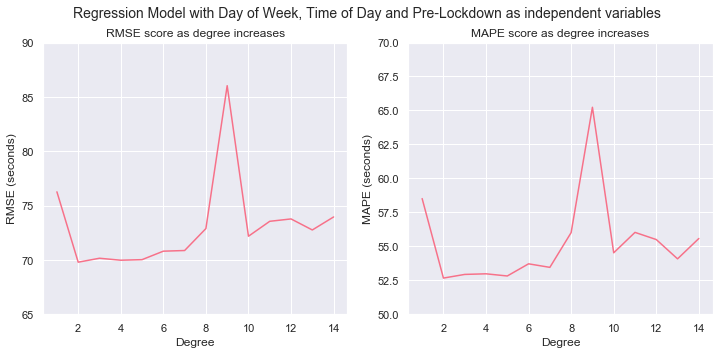

In [393]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].plot([i for i in range(1, len(rmse_mults2) + 1)], rmse_mults2)
ax[0].set_title("RMSE score as degree increases")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("RMSE (seconds)")
ax[0].set_ylim(65, 90)

ax[1].plot([i for i in range(1, len(mape_mults2) + 1)], mape_mults2)
ax[1].set_title("MAPE score as degree increases")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("MAPE (seconds)")
ax[1].set_ylim(50, 70)

fig.suptitle("Regression Model with Day of Week, Time of Day and Pre-Lockdown as independent variables", fontsize=14)
plt.show()

In [395]:
best_rmse_mult2 = min(rmse_mults2)
best_mape_mult2 = min(mape_mults2)
best_rmse_mult2_index = rmse_mults2.index(best_rmse_mult2)
best_mape_mult2_index = mape_mults2.index(best_mape_mult2)
print(best_rmse_mult2_index, best_mape_mult2_index)

1 1


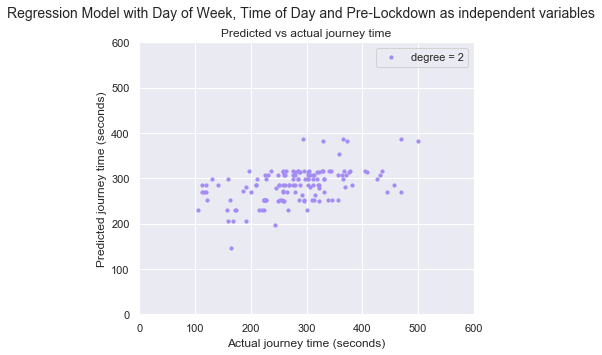

In [396]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(y_test_mult2, y_pred_mults2[best_rmse_mult2_index], label = "degree = {}".format(best_rmse_mult2_index + 1), color = cs[6], s = 10)
if best_rmse_mult2_index != best_mape_mult2_index:
    ax.scatter(y_test_mult2, y_pred_mults2[best_mape_mult2_index], label = "degree = {}".format(best_mape_mult2_index + 1), color = cs[3], alpha = 0.7, s = 10)
ax.set_title("Predicted vs actual journey time")
ax.set_xlabel("Actual journey time (seconds)")
ax.set_ylabel("Predicted journey time (seconds)")
ax.set_xlim(0, 600)
ax.set_ylim(0, 600)
ax.legend()

fig.suptitle("Regression Model with Day of Week, Time of Day and Pre-Lockdown as independent variables", fontsize=14)
plt.show()

## Compare the models

In [429]:
compare_mapes = [best_mape_tod, best_mape_dow, best_mape_mult, best_mape_mult2]
compare_rmses = [best_rmse_tod, best_rmse_dow, best_rmse_mult, best_rmse_mult2]
compare_mapes_indices = [best_mape_tod_index, best_mape_dow_index, best_mape_mult_index, best_mape_mult2_index]
compare_rmses_indices = [best_rmse_tod_index, best_rmse_dow_index, best_rmse_mult_index, best_rmse_mult2_index]
compare_mapes_degree = [x + 1 for x in compare_mapes_indices]
compare_rmses_degree = [x + 1 for x in compare_rmses_indices]

compare_labels = ["Time of day", "Day of week", "ToD + DoW", "ToD + DoW + Lockdown"]
best_mapes_zipped = list(zip(compare_mapes, compare_mapes_degree, compare_labels))
best_rmses_zipped = list(zip(compare_rmses, compare_rmses_degree, compare_labels))
print(best_mapes_zipped)
print(best_rmses_zipped)

[(58.44862981476179, 2, 'Time of day'), (65.70403661826637, 14, 'Day of week'), (56.08190548407646, 13, 'ToD + DoW'), (52.665604711352856, 2, 'ToD + DoW + Lockdown')]
[(77.7857208969304, 8, 'Time of day'), (83.93109179527758, 5, 'Day of week'), (75.97719359157101, 14, 'ToD + DoW'), (69.79338376930846, 2, 'ToD + DoW + Lockdown')]


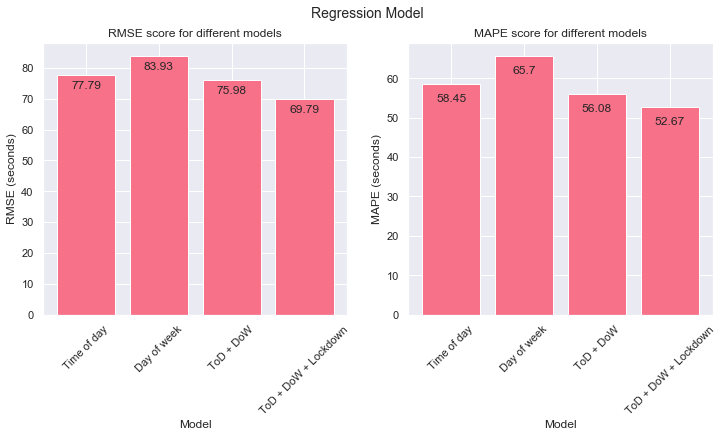

In [432]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)
plt.xticks(rotation=45)

ax[0].bar(compare_labels, compare_rmses)
ax[0].set_title("RMSE score for different models")
ax[0].set_xlabel("Model")
ax[0].set_ylabel("RMSE (seconds)")

for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

rects_rmse = ax[0].patches
labels_rmse = [round(best_rmse_tod, 2), round(best_rmse_dow, 2), round(best_rmse_mult, 2), round(best_rmse_mult2, 2)]

for rect, label in zip(rects_rmse, labels_rmse):
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')
    
ax[1].bar(compare_labels, compare_mapes)
ax[1].set_title("MAPE score for different models")
ax[1].set_xlabel("Model")
ax[1].set_ylabel("MAPE (seconds)")

rects_mape = ax[1].patches
labels_mape = [round(best_mape_tod, 2), round(best_mape_dow, 2), round(best_mape_mult, 2), round(best_mape_mult2, 2)]

for rect, label in zip(rects_mape, labels_mape):
    height = rect.get_height()
    ax[1].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')

fig.suptitle('Regression Model', fontsize=14)
plt.show()

According to both MAPE and RMSE, the best model is the one that has time of day and day of week as independent variables in the multilinear regression model with degree 3 and 7 respectively

TODO: In this case, is MAPE or RMSE a better measure of success?

The above values change depending on the split of training and testing -> might be necessary to do k-fold cross validation and get the average MAPE and average RMSE? Can email Peter to discuss

In [400]:
regression_mapes = compare_mapes
regression_rmses = compare_rmses

%store regression_mapes regression_rmses

Stored 'regression_mapes' (list)
Stored 'regression_rmses' (list)


## Testing out best model with larger gaps

Test the best 2 models. The 2 best models are the same for both MAPE and RMSE, so only need to test out 2 models.

1) multilinear regression based on time of day + day of week, degree = 3 and 7

2) multilinear regression based on time of day + day of week + pre lockdown, degree 2 and 3

In [440]:
best_model1, best_model2 = sorted(best_mapes_zipped, key = lambda t: t[0])[:2]
print(best_model1)
print(best_model2)

all_models = {
    "ToD": model_tods,
    "DoW": model_dows,
    "ToD + DoW": model_mults,
    "ToD + DoW + Lockdown": model_mults2
}

model1_degree = best_model1[1]
model1 = all_models.get(best_model1[2])[model1_degree - 1]

model2_degree = best_model2[1]
model2 = all_models.get(best_model2[2])[model2_degree - 1]

(52.665604711352856, 2, 'ToD + DoW + Lockdown')
(56.08190548407646, 13, 'ToD + DoW')


### Test the no 1 best model on gaps from size 5 to 35

In [348]:
print("Number of stops in route 52: ", len(stops_in_sequence_inbound.get("52")))
stop_a_gaps = stops_in_sequence_inbound.get("52")[1]

# Gap = 5
stop_b_5 = stops_in_sequence_inbound.get("52")[6]

# Gap = 10
stop_b_10 = stops_in_sequence_inbound.get("52")[11]

# Gap = 15
stop_b_15 = stops_in_sequence_inbound.get("52")[16]

# Gap = 20
stop_b_20 = stops_in_sequence_inbound.get("52")[21]

# Gap = 25
stop_b_25 = stops_in_sequence_inbound.get("52")[26]

# Gap = 30
stop_b_30 = stops_in_sequence_inbound.get("52")[31]

# Gap = 35
stop_b_35 = stops_in_sequence_inbound.get("52")[36]

destination_stops = [stop_b_5, stop_b_10, stop_b_15, stop_b_20, stop_b_25, stop_b_30, stop_b_35]
print("origin stop: ", stop_a_gaps)
print("destination stops: ", destination_stops)

Number of stops in route 52:  37
origin stop:  Willesden Bus Garage
destination stops:  ['Okehampton Road', 'Harrow Road / Kilburn Lane', 'Chesterton Road', 'Notting Hill Gate Station', 'Palace Gate', 'Knightsbridge Station  / Harrods', 'Victoria Bus Station']


In [349]:
b_52 = data.get("52")

stop_a = b_52.loc[(b_52['bus_stop_name'] == stop_a_gaps) & (b_52['direction'] == 'inbound')]
[_, a_id, _, _, _] = stop_a.iloc[0]['vehicle_id'].split('_')

stop_bs = []
for b in destination_stops:
    stop_b = b_52.loc[(b_52['bus_stop_name'] == b) & (b_52['direction'] == 'inbound')]
    stop_bs.append(stop_b)

In [350]:
def get_attrs(gap, stop_a, stop_b, a_id):
    start = time.time()
    
    # if gap == 5:
    min_time = 3
    max_time = 15
    
    if gap == 10:
        min_time = 10
        max_time = 22
    elif gap == 15:
        min_time = 15
        max_time = 30
    elif gap == 20:
        min_time = 20
        max_time = 40
    elif gap == 25:
        min_time = 31
        max_time = 55
    elif gap == 30:
        min_time = 40
        max_time = 70

    attributes = []
    for i, journey in stop_b.iterrows():

        arr_dt = convert_time_to_datetime(journey['time_of_arrival'])
        [bus_id, _, date, direction, _] = journey['vehicle_id'].split('_')
        to_match_id = bus_id + '_' + a_id + '_' + date + '_' + direction + '_'

        for j, match in stop_a.iterrows():
            if match['vehicle_id'].startswith(to_match_id):
                leave_dt = convert_time_to_datetime(match['time_of_arrival'])
                journey_time = arr_dt - leave_dt

                if (journey_time > dt.timedelta(minutes = min_time)) & (journey_time < dt.timedelta(minutes = max_time)):
                    item = []
                    item.append(journey_time)

                    seconds = journey_time.total_seconds()
                    item.append(seconds)

                    d = dt.datetime.strptime(match['time_of_arrival'][:10], '%Y-%m-%d')
                    d = calendar.day_name[d.weekday()]
                    w = weekday_or_weekend(d)
                    item.append(w)

                    t = int(journey['time_of_arrival'][11:13])
                    item.append(t)

                    c = pre_lockdown(journey['time_of_arrival'])
                    item.append(c)

                    attributes.append(item)
                    break

    print("Getting journey times took {}".format(time.time() - start))

    df = pd.DataFrame(attributes, columns = ['Journey Time', 'Journey Time (s)', 'Day of Week', 'Time of Day', 'Pre Lockdown'])

    encoded = dow_encoder.transform(df['Day of Week'])
    df['Day of Week Encoded'] = encoded
    encoded = ld_encoder.transform(df['Pre Lockdown'])
    df['Pre Lockdown Encoded'] = encoded
    
    return df

In [290]:
res = get_attrs(5, stop_a, stop_bs[0], a_id)
res.head()

Getting journey times took 212.14552283287048


,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Day of Week Encoded,Pre Lockdown Encoded
0,00:06:54,414.0,weekday,3,False,0,0
1,00:06:54,414.0,weekday,3,False,0,0
2,00:04:36,276.0,weekday,5,False,0,0
3,00:04:36,276.0,weekday,5,False,0,0
4,00:04:33,273.0,weekday,5,False,0,0


In [441]:
model1

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [401]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

df_gap = res.sort_values(["Time of Day", "Day of Week", "Pre Lockdown"])
poly1 = PolynomialFeatures(degree = model1_degree)

x_test_gap = poly1.transform(df_gap[['Time of Day', 'Day of Week', 'Pre Lockdown']])
y_test_gap = df_gap['Journey Time (s)'][:, np.newaxis]

# Scale the data
scaler = StandardScaler()
x_gap_scaled = scaler.fit_transform(x_test_gap)
    
# Predict
y_pred_gap = model1.predict(x_gap_scaled)

# Calculate measures of success
mse = mean_squared_error(y_test_gap, y_pred_gap)
rmse = np.sqrt(mse)
mape = mean_absolute_error(y_test_gap, y_pred_gap)

(281, 7) (282, 7) (282, 7) (282, 7)
(903, 7) (130, 7)


In [ ]:
for i, b in enumerate(stop_bs):
    
    res = get_attrs((i + 1) * 5, stop_a, b, a_id)

    df_mult = df.sort_values(["Time of Day", "Day of Week"])
    